<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/regular_L2regu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
#import libraries
import torch
import torch.nn as nn

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


<ipython-input-41-18bbc7a40f3b>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


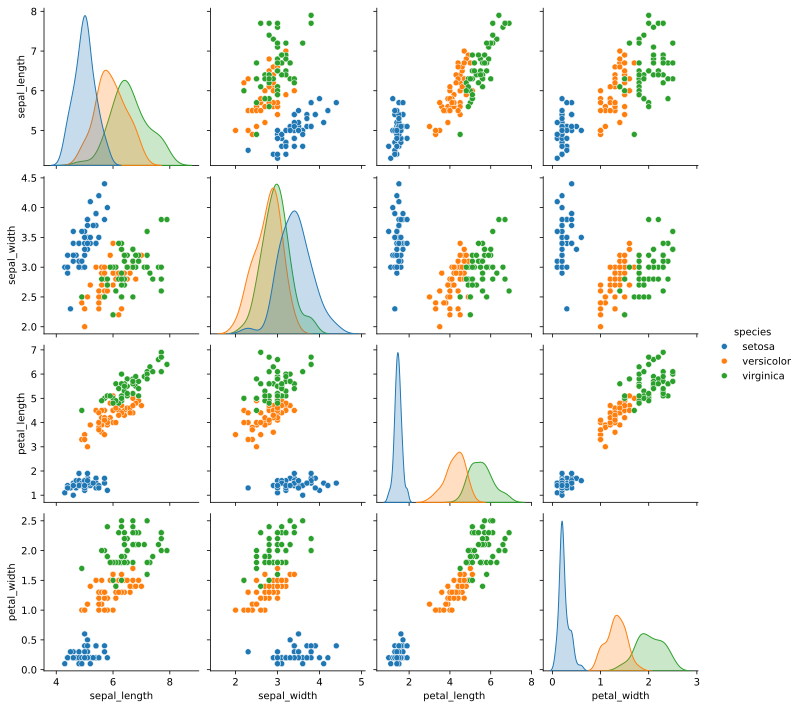

In [42]:
#import dataset(comes with seaborn)
import seaborn as sns
iris=sns.load_dataset('iris')
#check out the first few lines of data
iris.head()
#plot to show the data
sns.pairplot(iris, hue='species')
plt .show()

In [43]:
#organize the data
#convert form pandas dataframe to tensor
data=torch.tensor(iris[iris.columns[0:4]].values).float()
#transform species to number
labels=torch.zeros(len(data), dtype=torch.long)
#  0 not needed becauuse it is already initialized above
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2


Seperate the data into dataloader


In [44]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2)
#then convert them into Pytorch Datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [49]:
#a function that creates the ANN model
def createANewModel(L2lambda):
  #model architecture
  ANNiris=nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)
  )
  #loss function
  lossfun=nn.CrossEntropyLoss()
  #optimizer
  optimizer=torch.optim.SGD(ANNiris.parameters(),lr=0.005,weight_decay=L2lambda)
  return ANNiris,lossfun,optimizer

Create the model

In [50]:
#train the model
#training parameter
numepochs=1000
def trainTheModel():
  #initialize accuracies as empties(not storing losses here)
  trainAcc=[]
  testAcc=[]
  losses=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchloss=[]
    #switch training mode on
    ANNiris.train()
    for X,y in train_loader :
      #forward pass and loss
      yHat=ANNiris(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #compute accuracy
      batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
      batchloss.append(loss.item())
    #end of batch loop....
    #now that we've trained through the batches. get their training accuracy
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchloss))
    #TEST ACCURACY
    ANNiris.eval()
    X,y=next(iter(test_loader))
    yHat=ANNiris(X)
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
  #function output
  return trainAcc,testAcc,losses

TEST THE MODEL

In [51]:
#create a model
L2lambda=.01
ANNiris,lossfun,optimizer=createANewModel(L2lambda)
#train the model
trainAcc,testAcc,losses=trainTheModel()


In [52]:
#create a 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

Text(0, 0.5, 'Accuracy')

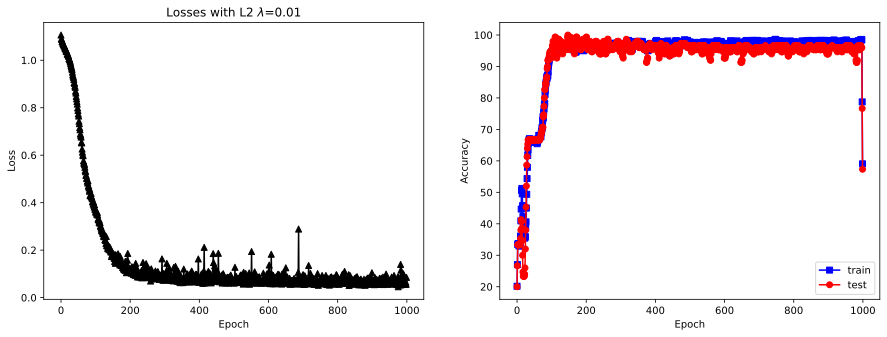

In [53]:
#plot the result
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses with L2 $\lambda$='+str(L2lambda))

ax[1].plot(smooth(trainAcc),'bs-')
ax[1].plot(smooth(testAcc),'ro-')
ax[1].legend(['train','test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')


Now for the test

In [54]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
  ANNiris,lossfun,optimizer = createANewModel(l2lambdas[li])
  trainAcc,testAcc,losses = trainTheModel()

  # store data
  accuracyResultsTrain[:,li] = smooth(trainAcc,10)
  accuracyResultsTest[:,li]  = smooth(testAcc,10)

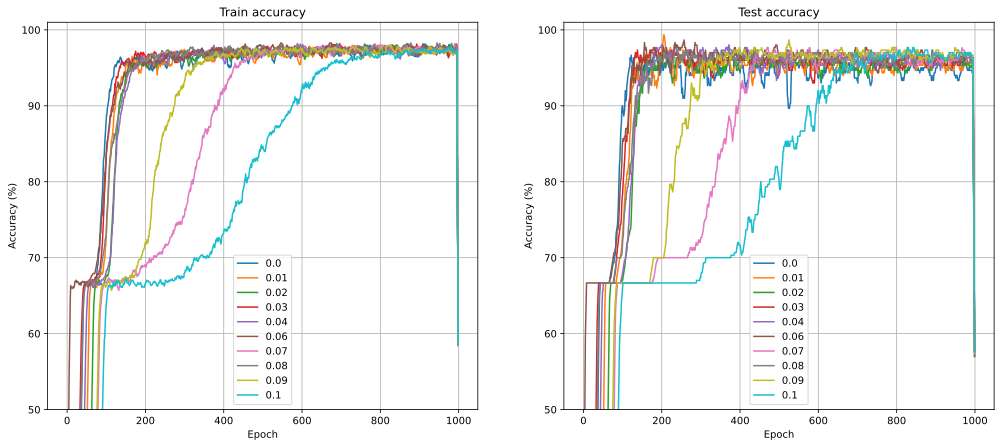

In [55]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()


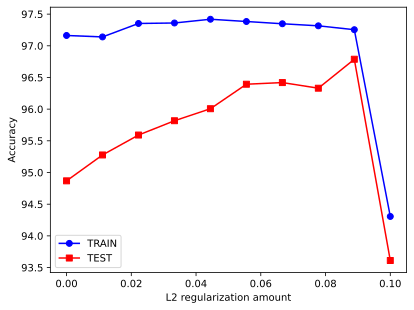

In [56]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()